##Data prep


In [ ]:
import csv
import cv2
from pandas import read_csv
import pandas as pd
import numpy as np

from math import sqrt
from numpy import ndarray
from datetime import datetime
from PIL import Image
from sklearn import preprocessing
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from keras.layers import Input, Flatten , Dense
from keras.models import Model

from keras.callbacks import EarlyStopping , ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = read_csv('data_classcsv.csv')

n=len(dataset)
image=[]
label=[]
for i in range(n):

    image.append(dataset['image'][i])

    label.append(dataset['label'][i])


In [ ]:
dataset

,image,label
0,1(1).JPG,cin front
1,145.jpg,cin front
2,2.JPG,cin front
3,3.JPG,cin front
4,4.JPG,cin front
...,...,...
196,kj7.jpg,cin back
197,kj8.jpg,cin back
198,kj9.jpg,cin back
199,kj10.jpg,cin back


In [ ]:
for i in range(n):
    if dataset['label'][i] == 'cin front' :
        dataset['label'][i]= 1
    if dataset['label'][i] == 'cin back' :
        dataset['label'][i]= 2
    if dataset['label'][i] == 'grise front' :
        dataset['label'][i]= 3
    if dataset['label'][i] == 'grise back' :
        dataset['label'][i]= 4


OneHotencoding for label

In [ ]:
dataset = pd.get_dummies(dataset, columns=['label'])

In [ ]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset=dataset.rename(columns={"label_1": "c1", "label_2": "c2", "label_3": "g1" ,  "label_4": "g2"})

In [ ]:
dataset

,image,c1,c2,g1,g2
0,22196282_10210154328840812_5391605901588911463...,0,1,0,0
1,b30.JPG,0,1,0,0
2,v5.jpg,0,0,1,0
3,c15.JPG,1,0,0,0
4,v8.jpg,0,0,1,0
...,...,...,...,...,...
196,p10.png,1,0,0,0
197,8875.png,1,0,0,0
198,6.JPG,1,0,0,0
199,cin1.png,1,0,0,0


efficient net b0 : (224,224,3) with range [255,0]
efficient net b4 : (380,380,3) with range [255,0]


In [ ]:
import os
label_name=[]
img_data_array=[]
def create_dataset(img_folder , file):




    image_path= os.path.join(img_folder,file)
    print(image_path)
    image= cv2.imread( image_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image=cv2.resize(image, (380, 380),interpolation = cv2.INTER_AREA)
    image = image.astype('float32')
    arr=np.array(image)


    img_data_array.append(arr)

    return img_data_array
# extract the image array and class name
#if cin front yaani label =1
for i in range(n):
    if dataset['c1'][i]==1 :
        img_data=create_dataset(r'/content/drive/MyDrive/carte grise/CIN front' , dataset['image'][i])
        label_name.append([1,0,0,0])
    if dataset['c2'][i]==1 :
        img_data=create_dataset(r'/content/drive/MyDrive/carte grise/cin back' , dataset['image'][i])
        label_name.append([0,1,0,0])
    if dataset['g1'][i]==1 :
        img_data=create_dataset(r'/content/drive/MyDrive/carte grise/carte grise front' , dataset['image'][i])
        label_name.append([0,0,1,0])
    if dataset['g2'][i]==1 :
        img_data=create_dataset(r'/content/drive/MyDrive/carte grise/carte grise back' , dataset['image'][i])
        label_name.append([0,0,0,1])

data split

In [ ]:
from sklearn.model_selection import train_test_split
img_data= np.array(img_data)
label_name=np.array(label_name)
x_train , x_test , y_train , y_test = train_test_split(img_data, label_name, test_size=0.3, random_state=7)


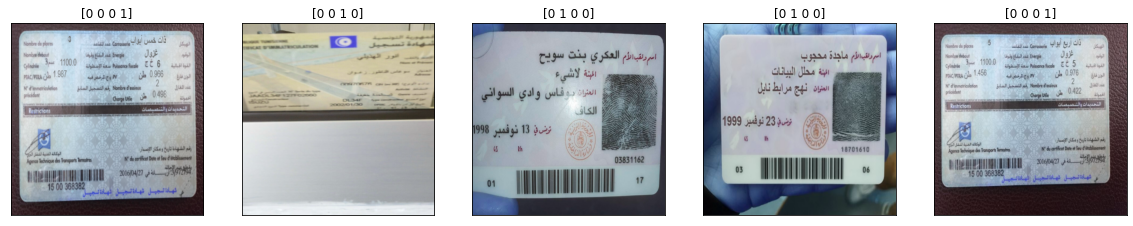

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

# plot first six training images
fig = plt.figure(figsize=(20,20))
for i in range(0,5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i].astype('uint8'))
    ax.set_title(str(y_train[i]))

##Efficientb4

In [ ]:
from keras import layers
from tensorflow.keras.applications import EfficientNetB0 ,EfficientNetB4
NUM_CLASSES = 4
IMG_SIZE = 380
size = (380, 380)
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = EfficientNetB4(include_top=False, input_tensor=x, weights="imagenet" , drop_connect_rate=0.7)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model(num_classes=4)
hist = model.fit(x_train, y_train,validation_data=(x_test , y_test), epochs=9, verbose=2)

Epoch 1/9
5/5 - 119s - loss: 1.7110 - accuracy: 0.5500 - val_loss: 0.2834 - val_accuracy: 0.9016 - 119s/epoch - 24s/step
Epoch 2/9
5/5 - 98s - loss: 0.3457 - accuracy: 0.9214 - val_loss: 0.3627 - val_accuracy: 0.8852 - 98s/epoch - 20s/step
Epoch 3/9
5/5 - 96s - loss: 0.3765 - accuracy: 0.9000 - val_loss: 0.4071 - val_accuracy: 0.8689 - 96s/epoch - 19s/step
Epoch 4/9
5/5 - 99s - loss: 0.0586 - accuracy: 0.9857 - val_loss: 0.2860 - val_accuracy: 0.9508 - 99s/epoch - 20s/step
Epoch 5/9
5/5 - 98s - loss: 0.0760 - accuracy: 0.9643 - val_loss: 0.2590 - val_accuracy: 0.9508 - 98s/epoch - 20s/step
Epoch 6/9
5/5 - 98s - loss: 0.3925 - accuracy: 0.9429 - val_loss: 0.2772 - val_accuracy: 0.9672 - 98s/epoch - 20s/step
Epoch 7/9
5/5 - 101s - loss: 0.0591 - accuracy: 0.9929 - val_loss: 0.3057 - val_accuracy: 0.9508 - 101s/epoch - 20s/step
Epoch 8/9
5/5 - 103s - loss: 0.0894 - accuracy: 0.9786 - val_loss: 0.3701 - val_accuracy: 0.9344 - 103s/epoch - 21s/step
Epoch 9/9
5/5 - 99s - loss: 0.1032 - accur

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:  0.9857142567634583\nValidation Accuracy: 0.868852436542511')

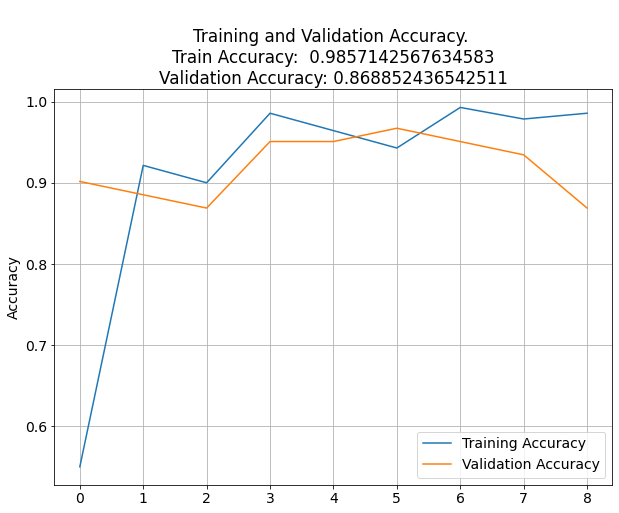

In [ ]:
# store results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:  {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

In [ ]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

from keras.models import load_model

model.save('my_model.h5')

INFO:tensorflow:Assets written to: ram://85da5da2-107e-4785-82be-77287ff298b8/assets


##Predict

(672, 1097, 3)
(1, 380, 380, 3)
predicted class: Cin back


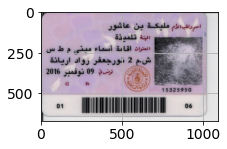

In [ ]:
img_path = r'/content/drive/MyDrive/carte grise/carte grise back/1.jpg'
img= cv2.imread("002.jpg")
plt.figure(figsize = (20,2))
plt.imshow(img)

#img = cv2.imread(img2)
print(img.shape)

image=cv2.resize(img, (380, 380),interpolation = cv2.INTER_AREA)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image = image.astype('float32')
image = image.reshape(1,380,380,3)
arr=np.array(image)
#print(arr/255.0)


print(arr.shape)

new_model = tf.keras.models.load_model('my_model.h5')
preds=new_model.predict(arr)
if preds[0][0].round() == 1.0 :
  print("predicted class: Cin front")
if preds[0][1].round() == 1.0 :
  print("predicted class: Cin back")
if preds[0][2].round() == 1.0 :
  print("predicted class: grise front")
if preds[0][3].round() == 1.0 :
  print("predicted class: grise back")



In [ ]:
print(tf. __version__)

2.8.0
